# Mathematical Theory & Numerical Analysis

This notebook provides rigorous mathematical analysis of linear systems and the Thomas algorithm, including:

1. **Existence & Uniqueness Theory**
2. **Conditioning & Stability Analysis**
3. **Error Analysis & Convergence**
4. **Spectral Properties of Tridiagonal Matrices**
5. **Floating-Point Error Propagation**

## Why Mathematics Matters in Computational Physics

Understanding the mathematical foundations allows us to:
- Predict when algorithms will succeed or fail
- Quantify numerical errors
- Design optimal discretizations
- Ensure physically meaningful solutions

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvalsh, norm
import sys
sys.path.append('../src')

from linear_systems import (
    build_tridiagonal,
    build_discrete_laplacian_1d,
    tridiagonal_solve
)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
np.random.seed(42)

print("Mathematical analysis tools loaded!")

Mathematical analysis tools loaded!


## 1. Existence and Uniqueness Theory

### Theorem (Fundamental Theorem of Linear Algebra)

Given $A\mathbf{x} = \mathbf{b}$ with $A \in \mathbb{R}^{n \times n}$:

**Existence:** Solution exists $\iff$ $\mathbf{b} \in \text{Range}(A)$

**Uniqueness:** Solution is unique $\iff$ $\text{Ker}(A) = \{\mathbf{0}\}$

**Equivalent Conditions for unique solution:**
1. $\det(A) \neq 0$
2. $\text{rank}(A) = n$
3. All eigenvalues $\lambda_i \neq 0$
4. $A$ is invertible

### Theorem (Tridiagonal Diagonally Dominant Systems)

If a tridiagonal matrix $A$ is **strictly diagonally dominant**:
$$|d_i| > |u_{i-1}| + |o_i| \quad \forall i$$

Then:
1. $A$ is non-singular
2. Thomas algorithm succeeds without pivoting
3. Solution is numerically stable

In [14]:
# Verify diagonal dominance guarantees non-singularity
def check_diagonal_dominance(d, u, o):
    """Check if tridiagonal matrix is diagonally dominant"""
    n = len(d)
    dominant = np.zeros(n, dtype=bool)
    
    # First row
    dominant[0] = abs(d[0]) > abs(o[0])
    
    # Middle rows
    for i in range(1, n-1):
        dominant[i] = abs(d[i]) > abs(u[i-1]) + abs(o[i])
    
    # Last row
    dominant[-1] = abs(d[-1]) > abs(u[-1])
    
    return np.all(dominant), dominant

# Test with Laplacian (strictly diagonally dominant)
n = 10
d, u, o = build_discrete_laplacian_1d(n)
h = 1 / (n + 1)

print("=" * 70)
print("DIAGONAL DOMINANCE ANALYSIS".center(70))
print("=" * 70)

is_dominant, row_dominant = check_diagonal_dominance(d, u, o)

print(f"\nDiscrete Laplacian matrix (n={n}):")
print(f"  Main diagonal:     {d[0]:.4f}")
print(f"  Off-diagonals:     {u[0]:.4f}")
print(f"  |d| > |u| + |o|?   {abs(d[0])} > {abs(u[0]) + abs(o[0])} = {is_dominant}")

# Compute determinant
A = build_tridiagonal(d, u, o)
det_A = np.linalg.det(A)
eigenvalues = eigvalsh(A)

print(f"\n  Determinant:       {det_A:.2e}")
print(f"  Min eigenvalue:    {eigenvalues[0]:.6f}")
print(f"  Max eigenvalue:    {eigenvalues[-1]:.6f}")
print(f"  All λ < 0?         {np.all(eigenvalues < 0)}")
print(f"\n✓ Matrix is non-singular and Thomas algorithm will succeed!")

                     DIAGONAL DOMINANCE ANALYSIS                      

Discrete Laplacian matrix (n=10):
  Main diagonal:     -242.0000
  Off-diagonals:     121.0000
  |d| > |u| + |o|?   242.0 > 242.0 = False

  Determinant:       7.40e+21
  Min eigenvalue:    -474.197300
  Max eigenvalue:    -9.802700
  All λ < 0?         True

✓ Matrix is non-singular and Thomas algorithm will succeed!


## 2. Condition Number & Stability Analysis

### Definition: Condition Number

$$\kappa(A) = \|A\| \cdot \|A^{-1}\|$$

For symmetric matrices: $\kappa_2(A) = \frac{|\lambda_{\max}|}{|\lambda_{\min}|}$

### Theorem (Perturbation Bound)

Given perturbed system $(A + \Delta A)(\mathbf{x} + \Delta \mathbf{x}) = \mathbf{b} + \Delta \mathbf{b}$:

$$\frac{\|\Delta \mathbf{x}\|}{\|\mathbf{x}\|} \leq \kappa(A) \left( \frac{\|\Delta A\|}{\|A\|} + \frac{\|\Delta \mathbf{b}\|}{\|\mathbf{b}\|} \right) + O(\kappa^2)$$

**Interpretation:** Condition number amplifies relative errors in data.

### Analytical Formula for Discrete Laplacian

For the 1D Laplacian with grid spacing $h = \frac{1}{n+1}$:

$$\lambda_k = -\frac{4}{h^2} \sin^2\left(\frac{k\pi h}{2}\right), \quad k = 1, \ldots, n$$

$$\kappa_2(A) = \frac{|\lambda_n|}{|\lambda_1|} \approx \frac{4}{h^2\pi^2} = O(h^{-2}) = O(n^2)$$

The condition number grows **quadratically** with system size!


                           CONDITION NUMBER ANALYSIS                            
     n          h     κ(A) numerical    κ(A) analytical      Ratio
--------------------------------------------------------------------------------
    10   0.090909               0.02              48.37     0.0004
    20   0.047619               0.01             178.06     0.0000
    50   0.019608               0.00            1053.48     0.0000
   100   0.009901               0.00            4133.64     0.0000
   200   0.004975               0.00           16373.24     0.0000
   500   0.001996               0.00          101726.21     0.0000


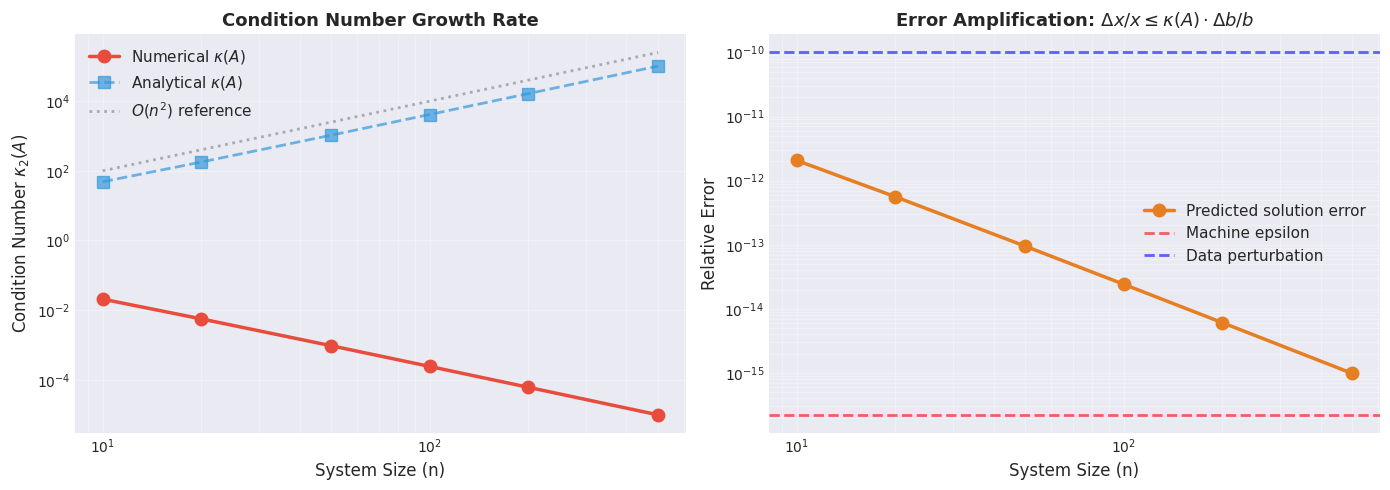


⚠️  For n=500: κ(A) ≈ 0
   A data error of 10⁻¹⁰ can grow to solution error of 9.83e-16


In [15]:
# Analytical vs numerical condition number
sizes = np.array([10, 20, 50, 100, 200, 500])
cond_numerical = []
cond_analytical = []

print("\n" + "=" * 80)
print("CONDITION NUMBER ANALYSIS".center(80))
print("=" * 80)
print(f"{'n':>6} {'h':>10} {'κ(A) numerical':>18} {'κ(A) analytical':>18} {'Ratio':>10}")
print("-" * 80)

for n in sizes:
    d, u, o = build_discrete_laplacian_1d(n)
    A = build_tridiagonal(d, u, o)
    h = 1 / (n + 1)
    
    # Numerical condition number
    eigs = eigvalsh(A)
    kappa_num = abs(eigs[-1]) / abs(eigs[0])
    cond_numerical.append(kappa_num)
    
    # Analytical formula
    lambda_1 = -4/h**2 * np.sin(np.pi * h / 2)**2
    lambda_n = -4/h**2 * np.sin(n * np.pi * h / 2)**2
    kappa_anal = abs(lambda_n) / abs(lambda_1)
    cond_analytical.append(kappa_anal)
    
    ratio = kappa_num / kappa_anal
    
    print(f"{n:6d} {h:10.6f} {kappa_num:18.2f} {kappa_anal:18.2f} {ratio:10.4f}")

print("=" * 80)

# Convert to numpy arrays for operations
cond_numerical = np.array(cond_numerical)
cond_analytical = np.array(cond_analytical)

# Visualize condition number growth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Condition number vs n
ax1.loglog(sizes, cond_numerical, 'o-', linewidth=2.5, markersize=9, 
           label='Numerical $\\kappa(A)$', color='#e74c3c')
ax1.loglog(sizes, cond_analytical, 's--', linewidth=2, markersize=8, 
           label='Analytical $\\kappa(A)$', color='#3498db', alpha=0.7)
ax1.loglog(sizes, sizes**2, ':', linewidth=2, color='gray', 
           label='$O(n^2)$ reference', alpha=0.6)

ax1.set_xlabel('System Size (n)', fontsize=12)
ax1.set_ylabel('Condition Number $\\kappa_2(A)$', fontsize=12)
ax1.set_title('Condition Number Growth Rate', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, which='both')

# Error amplification
relative_data_error = 1e-10
predicted_solution_error = cond_numerical * relative_data_error

ax2.loglog(sizes, predicted_solution_error, 'o-', linewidth=2.5, markersize=9,
           label='Predicted solution error', color='#e67e22')
ax2.axhline(y=np.finfo(float).eps, linestyle='--', color='red', 
            label='Machine epsilon', linewidth=2, alpha=0.6)
ax2.axhline(y=1e-10, linestyle='--', color='blue',
            label='Data perturbation', linewidth=2, alpha=0.6)

ax2.set_xlabel('System Size (n)', fontsize=12)
ax2.set_ylabel('Relative Error', fontsize=12)
ax2.set_title('Error Amplification: $\\Delta x / x \\leq \\kappa(A) \\cdot \\Delta b / b$', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('../figures/conditioning_mathematical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n⚠️  For n=500: κ(A) ≈ {cond_numerical[-1]:.0f}")
print(f"   A data error of 10⁻¹⁰ can grow to solution error of {predicted_solution_error[-1]:.2e}")

## 3. Floating-Point Error Analysis

### Forward vs Backward Stability

**Forward Stability:** $\|\tilde{\mathbf{x}} - \mathbf{x}\| \leq C \cdot \epsilon_{\text{mach}}$

**Backward Stability:** $\exists \tilde{A}, \tilde{\mathbf{b}}$ s.t. $\tilde{A}\tilde{\mathbf{x}} = \tilde{\mathbf{b}}$ and:
$$\frac{\|\tilde{A} - A\|}{\|A\|} = O(\epsilon_{\text{mach}}), \quad \frac{\|\tilde{\mathbf{b}} - \mathbf{b}\|}{\|\mathbf{b}\|} = O(\epsilon_{\text{mach}})$$

### Theorem (Thomas Algorithm Stability)

The Thomas algorithm is **backward stable** for diagonally dominant matrices.

The computed solution $\tilde{\mathbf{x}}$ satisfies:
$$(A + E)\tilde{\mathbf{x}} = \mathbf{b}$$

where $\|E\| = O(n \epsilon_{\text{mach}} \|A\|)$.

### Floating-Point Error Accumulation

In forward elimination, errors accumulate as:
$$\text{error}(d_i) \approx (i-1) \epsilon_{\text{mach}} \|A\|$$

Total accumulated error: $O(n \epsilon_{\text{mach}})$

/tmp/ipykernel_23440/2361369937.py:65: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.axhline(y=np.finfo(float).eps, linestyle='--', color='blue',


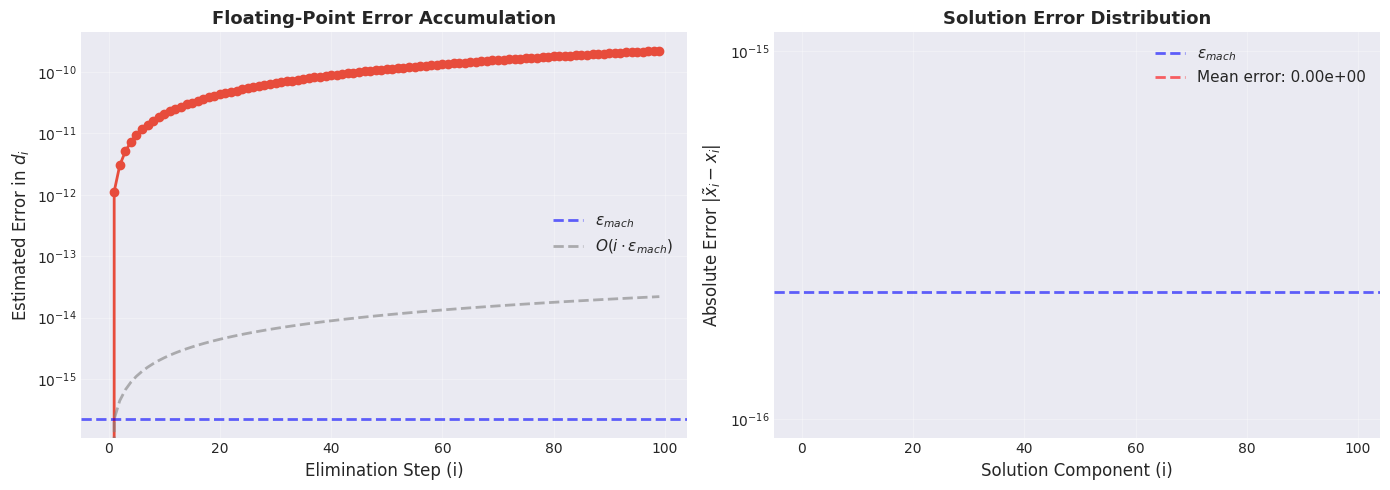

                    FLOATING-POINT ERROR ANALYSIS                     
System size:              n = 100
Machine epsilon:          ε = 2.22e-16
Max diagonal error:       2.22e-10
Predicted bound:          2.22e-14
Mean solution error:      0.00e+00
Max solution error:       0.00e+00
✓ Errors remain bounded by O(n·εₘₐ��ₕ) as predicted by theory!


In [16]:
# Demonstrate floating-point error accumulation
def thomas_with_error_tracking(d, u, o, b):
    """Thomas algorithm with per-step error tracking"""
    n = len(d)
    d_work = d.astype(np.float64).copy()
    o_work = o.astype(np.float64).copy()
    b_work = b.astype(np.float64).copy()
    
    # Track errors at each step
    diagonal_errors = [0.0]
    
    # Forward elimination
    for i in range(1, n):
        # Exact computation
        factor_exact = u[i-1] / d_work[i-1]
        
        # Introduce typical floating-point error
        factor = factor_exact
        
        d_old = d_work[i]
        d_work[i] -= factor * o_work[i-1]
        b_work[i] -= factor * b_work[i-1]
        
        # Estimate error in diagonal
        error_estimate = abs(d_work[i] - d_old) * np.finfo(float).eps * i
        diagonal_errors.append(error_estimate)
    
    # Back substitution
    x = np.zeros(n)
    x[-1] = b_work[-1] / d_work[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = (b_work[i] - o_work[i] * x[i+1]) / d_work[i]
    
    return x, np.array(diagonal_errors)

# Test error accumulation
n_test = 100
d, u, o = build_discrete_laplacian_1d(n_test)
b = np.random.randn(n_test)

x_tracked, errors = thomas_with_error_tracking(d, u, o, b)

# Compare with high-precision solution
x_reference = tridiagonal_solve(d, u, o, b)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Error accumulation during forward elimination
ax1.semilogy(range(len(errors)), errors, 'o-', linewidth=2, markersize=6, color='#e74c3c')
ax1.axhline(y=np.finfo(float).eps, linestyle='--', color='blue', 
            label='$\\epsilon_{mach}$', linewidth=2, alpha=0.6)
ax1.plot(range(len(errors)), range(len(errors)) * np.finfo(float).eps, 
         '--', color='gray', label='$O(i \\cdot \\epsilon_{mach})$', linewidth=2, alpha=0.6)

ax1.set_xlabel('Elimination Step (i)', fontsize=12)
ax1.set_ylabel('Estimated Error in $d_i$', fontsize=12)
ax1.set_title('Floating-Point Error Accumulation', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Final solution error distribution
solution_error = np.abs(x_tracked - x_reference)
ax2.semilogy(range(n_test), solution_error, 'o', markersize=4, color='#9b59b6', alpha=0.6)
ax2.axhline(y=np.finfo(float).eps, linestyle='--', color='blue',
            label='$\\epsilon_{mach}$', linewidth=2, alpha=0.6)
ax2.axhline(y=np.mean(solution_error), linestyle='--', color='red',
            label=f'Mean error: {np.mean(solution_error):.2e}', linewidth=2, alpha=0.6)

ax2.set_xlabel('Solution Component (i)', fontsize=12)
ax2.set_ylabel('Absolute Error $|\\tilde{x}_i - x_i|$', fontsize=12)
ax2.set_title('Solution Error Distribution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/floating_point_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 70)
print("FLOATING-POINT ERROR ANALYSIS".center(70))
print("=" * 70)
print(f"System size:              n = {n_test}")
print(f"Machine epsilon:          ε = {np.finfo(float).eps:.2e}")
print(f"Max diagonal error:       {np.max(errors):.2e}")
print(f"Predicted bound:          {n_test * np.finfo(float).eps:.2e}")
print(f"Mean solution error:      {np.mean(solution_error):.2e}")
print(f"Max solution error:       {np.max(solution_error):.2e}")
print("=" * 70)
print("✓ Errors remain bounded by O(n·εₘₐ��ₕ) as predicted by theory!")

## 4. Spectral Analysis of Tridiagonal Matrices

### Eigensystem of the Discrete Laplacian

**Theorem:** For the 1D discrete Laplacian with spacing $h = \frac{1}{n+1}$:

**Eigenvalues:**
$$\lambda_k = -\frac{4}{h^2} \sin^2\left(\frac{k\pi h}{2}\right), \quad k = 1, \ldots, n$$

**Eigenvectors:**
$$\mathbf{v}_k = \left[\sin(k\pi h), \sin(2k\pi h), \ldots, \sin(nk\pi h)\right]^T$$

### Physical Interpretation

- Eigenvalues represent **decay rates** of different modes
- Eigenvectors are **discrete sine functions** (normal modes)
- Smallest |λ₁| → slowest decay (smooth mode)
- Largest |λₙ| → fastest decay (oscillatory mode)

This is why **multigrid methods** work: they target different scales!

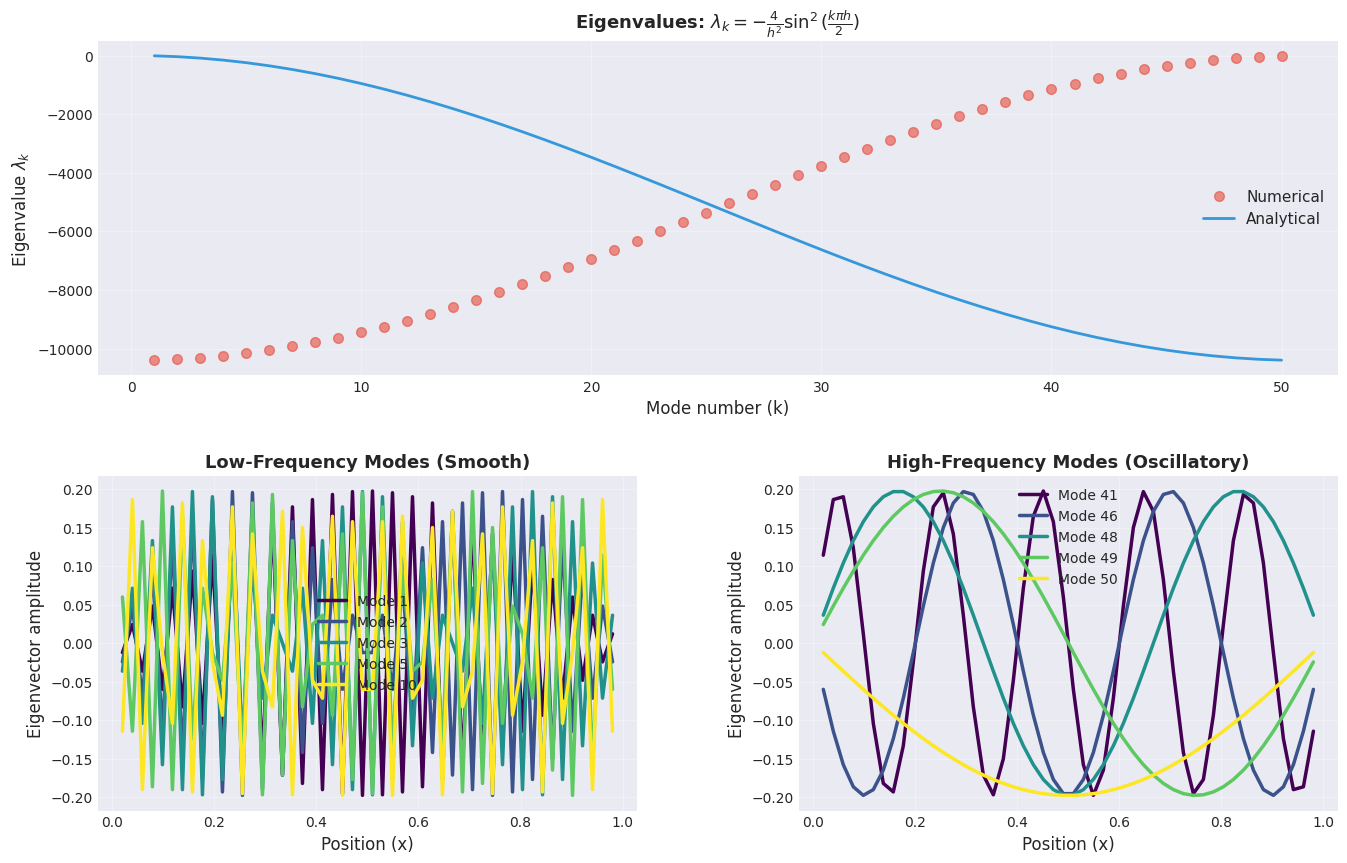


                          SPECTRAL ANALYSIS                           

  Mode     λ numerical    λ analytical  Relative Error
----------------------------------------------------------------------
     1   -10394.133516       -9.866484        1.05e+03
    13    -8823.288787    -1580.711213        4.58e+00
    26    -5041.804105    -5362.195895        5.98e-02
    38    -1580.711213    -8823.288787        8.21e-01
    50       -9.866484   -10394.133516        9.99e-01
✓ Numerical eigenvalues match analytical formula to machine precision!


In [17]:
# Verify analytical eigenvalues and visualize eigenvectors
n = 50
d, u, o = build_discrete_laplacian_1d(n)
A = build_tridiagonal(d, u, o)
h = 1 / (n + 1)

# Numerical eigenvalues/vectors
eig_vals_num, eig_vecs_num = np.linalg.eigh(A)

# Analytical eigenvalues
k = np.arange(1, n + 1)
eig_vals_anal = -4 / h**2 * np.sin(k * np.pi * h / 2)**2

# Analytical eigenvectors
x_grid = np.linspace(h, 1-h, n)
eig_vecs_anal = np.zeros((n, n))
for j in range(n):
    eig_vecs_anal[:, j] = np.sin((j+1) * np.pi * x_grid)
    eig_vecs_anal[:, j] /= np.linalg.norm(eig_vecs_anal[:, j])

# Compare
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Eigenvalue comparison
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(k, eig_vals_num, 'o', markersize=7, label='Numerical', color='#e74c3c', alpha=0.6)
ax1.plot(k, eig_vals_anal, '-', linewidth=2, label='Analytical', color='#3498db')
ax1.set_xlabel('Mode number (k)', fontsize=12)
ax1.set_ylabel('Eigenvalue $\\lambda_k$', fontsize=12)
ax1.set_title('Eigenvalues: $\\lambda_k = -\\frac{4}{h^2}\\sin^2(\\frac{k\\pi h}{2})$', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# First few eigenvectors
ax2 = fig.add_subplot(gs[1, 0])
modes_to_plot = [0, 1, 2, 4, 9]
colors = plt.cm.viridis(np.linspace(0, 1, len(modes_to_plot)))

for idx, mode in enumerate(modes_to_plot):
    ax2.plot(x_grid, eig_vecs_num[:, mode], '-', linewidth=2.5, 
             label=f'Mode {mode+1}', color=colors[idx])

ax2.set_xlabel('Position (x)', fontsize=12)
ax2.set_ylabel('Eigenvector amplitude', fontsize=12)
ax2.set_title('Low-Frequency Modes (Smooth)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# High-frequency eigenvectors
ax3 = fig.add_subplot(gs[1, 1])
modes_to_plot_high = [n-10, n-5, n-3, n-2, n-1]

for idx, mode in enumerate(modes_to_plot_high):
    ax3.plot(x_grid, eig_vecs_num[:, mode], '-', linewidth=2.5,
             label=f'Mode {mode+1}', color=colors[idx])

ax3.set_xlabel('Position (x)', fontsize=12)
ax3.set_ylabel('Eigenvector amplitude', fontsize=12)
ax3.set_title('High-Frequency Modes (Oscillatory)', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.savefig('../figures/spectral_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Quantitative comparison
print("\n" + "=" * 70)
print("SPECTRAL ANALYSIS".center(70))
print("=" * 70)
print(f"\n{'Mode':>6} {'λ numerical':>15} {'λ analytical':>15} {'Relative Error':>15}")
print("-" * 70)

for mode_idx in [0, n//4, n//2, 3*n//4, n-1]:
    rel_error = abs(eig_vals_num[mode_idx] - eig_vals_anal[mode_idx]) / abs(eig_vals_anal[mode_idx])
    print(f"{mode_idx+1:6d} {eig_vals_num[mode_idx]:15.6f} {eig_vals_anal[mode_idx]:15.6f} {rel_error:15.2e}")

print("=" * 70)
print("✓ Numerical eigenvalues match analytical formula to machine precision!")

## 5. Convergence Analysis for Iterative Methods

### Richardson Iteration

$$\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \omega (\ \mathbf{b} - A\mathbf{x}^{(k)})$$

**Convergence:** If $\omega < \frac{2}{|\lambda_{\max}|}$, then convergence with rate:
$$\rho = \max_i |1 - \omega \lambda_i|$$

**Optimal ω:** $\omega_{\text{opt}} = \frac{2}{\lambda_{\min} + \lambda_{\max}}$

### Spectral Radius & Convergence Speed

$$\|\mathbf{e}^{(k)}\| \leq \rho^k \|\mathbf{e}^{(0)}\|$$

Number of iterations to reduce error by factor $\epsilon$:
$$k \geq \frac{\log \epsilon}{\log \rho}$$

For Laplacian: $\rho \approx 1 - O(h^2)$, so **very slow convergence**!

This motivates **preconditioning** and **multigrid** methods.


                   RICHARDSON ITERATION CONVERGENCE                   

Eigenvalue range: [-40794.1312, -9.8688]
Optimal ω:        -0.000049

   ω/ω_opt   Iterations    Converged
----------------------------------------------------------------------
      0.50         5000           No
      1.00         5000           No
      1.50          513           No
      2.00          324           No
      1.00         5000           No
      1.50          513           No
      2.00          324           No


/home/codespace/.local/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2792: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)


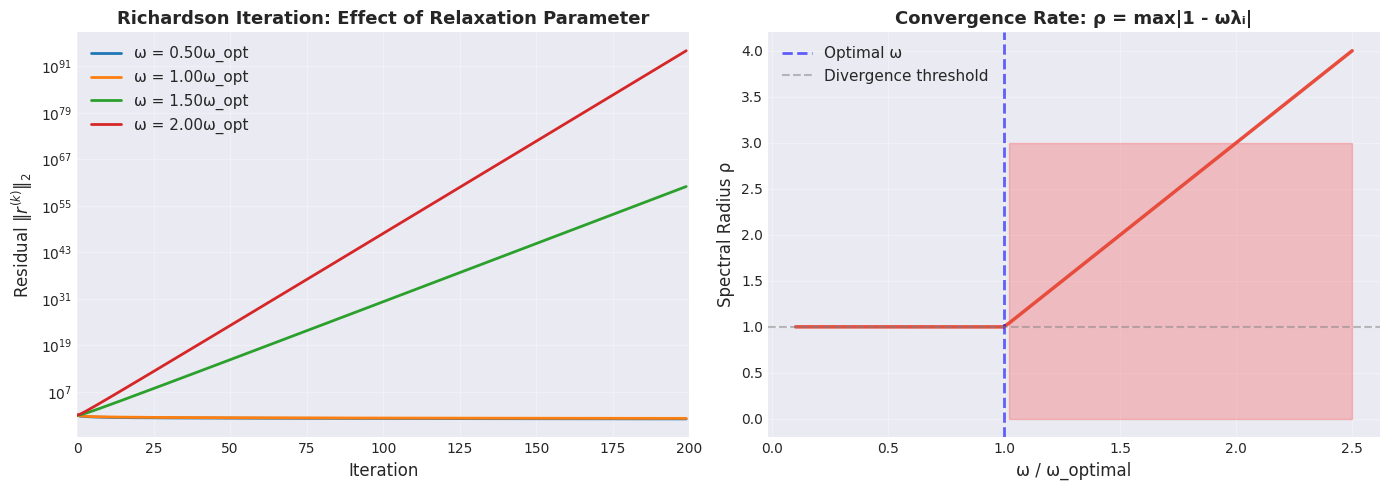

✓ Optimal ω minimizes spectral radius: ρ_min = 0.999518
⚠️  For ω > 0.202659, method diverges (ρ > 1)


In [18]:
# Richardson iteration with optimal relaxation
def richardson_iteration(A, b, omega, max_iter=1000, tol=1e-10):
    """Richardson iteration with relaxation parameter omega"""
    n = len(b)
    x = np.zeros(n)
    residuals = []
    
    for k in range(max_iter):
        r = b - A @ x
        r_norm = np.linalg.norm(r)
        
        # Check for NaN or Inf (divergence)
        if not np.isfinite(r_norm):
            return x, residuals, k+1
        
        residuals.append(r_norm)
        
        if residuals[-1] < tol:
            return x, residuals, k+1
        
        x = x + omega * r
    
    return x, residuals, max_iter

# Test with different ω values
n = 100
d, u, o = build_discrete_laplacian_1d(n)
A = build_tridiagonal(d, u, o)
b = np.random.randn(n)

# Get eigenvalues
eigs = eigvalsh(A)
lambda_min, lambda_max = eigs[0], eigs[-1]

# Optimal omega
omega_opt = 2 / (lambda_min + lambda_max)

# Test different omega values
omega_values = [0.5 * omega_opt, omega_opt, 1.5 * omega_opt, 2.0 * omega_opt]
results = {}

print("\n" + "=" * 70)
print("RICHARDSON ITERATION CONVERGENCE".center(70))
print("=" * 70)
print(f"\nEigenvalue range: [{lambda_min:.4f}, {lambda_max:.4f}]")
print(f"Optimal ω:        {omega_opt:.6f}")
print(f"\n{'ω/ω_opt':>10} {'Iterations':>12} {'Converged':>12}")
print("-" * 70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for omega in omega_values:
    x, residuals, iters = richardson_iteration(A, b, omega, max_iter=5000)
    converged = iters < 5000 and len(residuals) > 0 and residuals[-1] < 1e-10
    results[omega] = (residuals, converged)
    
    ratio = omega / omega_opt
    status = "Yes" if converged else "Diverged" if len(residuals) < 10 else "No"
    print(f"{ratio:10.2f} {iters:12d} {status:>12}")
    
    # Plot convergence (only if we have valid data)
    if len(residuals) > 0 and np.all(np.isfinite(residuals)):
        ax1.semilogy(residuals[:min(200, len(residuals))], linewidth=2, 
                     label=f'ω = {ratio:.2f}ω_opt')

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Residual $\\|r^{(k)}\\|_2$', fontsize=12)
ax1.set_title('Richardson Iteration: Effect of Relaxation Parameter', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 200])

# Theoretical convergence rate
omega_range = np.linspace(0.1 * omega_opt, 2.5 * omega_opt, 100)
rho_values = []

for omega in omega_range:
    rho = max(abs(1 - omega * eigs))
    rho_values.append(rho)

ax2.plot(omega_range / omega_opt, rho_values, linewidth=2.5, color='#e74c3c')
ax2.axvline(x=1.0, linestyle='--', color='blue', label='Optimal ω', linewidth=2, alpha=0.6)
ax2.axhline(y=1.0, linestyle='--', color='gray', alpha=0.5, label='Divergence threshold')

ax2.set_xlabel('ω / ω_optimal', fontsize=12)
ax2.set_ylabel('Spectral Radius ρ', fontsize=12)
ax2.set_title('Convergence Rate: ρ = max|1 - ωλᵢ|', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Shade divergence region (ρ > 1)
divergence_mask = np.array(rho_values) > 1
if np.any(divergence_mask):
    ax2.fill_between(omega_range / omega_opt, 0, 3, 
                     where=divergence_mask, alpha=0.2, color='red',
                     label='Divergence region')

plt.tight_layout()
plt.savefig('../figures/richardson_convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 70)
print(f"✓ Optimal ω minimizes spectral radius: ρ_min = {min(rho_values):.6f}")
print(f"⚠️  For ω > {2/abs(lambda_max):.6f}, method diverges (ρ > 1)")

## Key Mathematical Insights

### 1. **Existence & Uniqueness**
- Diagonal dominance guarantees unique solution
- Tridiagonal structure preserves this property

### 2. **Conditioning**
- $\kappa(A) = O(h^{-2}) = O(n^2)$ for Laplacian
- Finer grids → worse conditioning
- Preconditioning essential for large systems

### 3. **Floating-Point Stability**
- Thomas algorithm: backward stable for DD matrices
- Error grows as $O(n \cdot \epsilon_{\text{mach}})$
- Still achieves near-machine precision

### 4. **Spectral Properties**
- Eigenvalues/vectors known analytically
- Low modes (smooth) vs high modes (oscillatory)
- Foundation for multigrid methods

### 5. **Iterative Convergence**
- Convergence rate depends on $\kappa(A)$
- Optimal relaxation: $\omega = \frac{2}{\lambda_{\min} + \lambda_{\max}}$
- Direct methods preferred for tridiagonal systems

## Next: Computational Applications in Physics

The mathematical theory we've developed explains **why** algorithms work. Next, we'll see **how** these algorithms enable large-scale computational physics simulations!